In [2]:
from typing import List, Dict
import numpy as np

from PV_Generation import generate_PV_profile
from Load_Profiles import generate_load_profile
from Price_Forecast import generate_price_profile
from Agents import Prosumer
from Market import match_trades, match_local_market
from Regulator import Regulator
from BlockChain import Blockchain


In [3]:
def run_simulation(
    num_prosumers: int = 100,
    num_steps: int = 24,
    block_chain_difficulty: int = 3
) -> Dict:

    # ---------------- Initialization ----------------

    prosumers: List[Prosumer] = []
    for i in range(num_prosumers):
        has_pv = (i < int(0.7 * num_prosumers))
        prosumers.append(Prosumer(id=i, has_pv=has_pv))

    pv, capacities = generate_PV_profile(num_prosumers, num_steps)
    loads = generate_load_profile(num_prosumers, num_steps)
    grid_price, fit_price = generate_price_profile(num_steps)

    regulator = Regulator(objective="maximize_p2p")

    blockchain = Blockchain(
        difficulty=block_chain_difficulty,
        miner_ids=list(range(10))
    )

    history = {
        "total_load": [],
        "total_pv": [],
        "p2p_energy": [],
        "local_energy": [],
        "grid_import": [],
        "grid_export": [],
        "community_profit": [],
        "p2p_share": [],
        "objective_value": []
    }

    # ---------------- Time loop ----------------
    for t in range(num_steps):

        asks = []
        bids = []
        
        imbalances = np.zeros(num_prosumers)

        sold = np.zeros(num_prosumers)
        bought = np.zeros(num_prosumers)

        # ---- Self-balance + offers ----
        for i, p in enumerate(prosumers):

            pv_t = pv[i, t] if p.has_pv else 0.0
            load_t = loads[i, t]

            imbalance = p.self_balance(load_t, pv_t)
            imbalances[i] = imbalance

            role, qty, price = p.decide_P2P_offer(
                imbalance=imbalance,
                grid_price_t=grid_price[t]
            )

            if role == "seller":
                asks.append((p.id, qty, price))
            elif role == "buyer":
                bids.append((p.id, qty, price))

        # ---- P2P market ----
        p2p_trades, rem_asks, rem_bids = match_trades(asks, bids)

        # ---- Local market ----
        local_trades, _, _ = match_local_market(
            rem_asks, rem_bids, grid_price[t]
        )

        p2p_energy = 0.0
        local_energy = 0.0

        # ---- Apply trades ----

        for tr in p2p_trades:
            s, b = tr["seller"], tr["buyer"]
            q, pr = tr["quantity_kwh"], tr["price"]

            prosumers[s].apply_trade_result("seller", q, pr)
            prosumers[b].apply_trade_result("buyer", q, pr)

            sold[s] += q
            bought[b] += q
            p2p_energy += q

        for tr in local_trades:
            s, b = tr["seller"], tr["buyer"]
            q, pr = tr["quantity"], tr["price"]


            prosumers[s].apply_trade_result("seller", q, pr)
            prosumers[b].apply_trade_result("buyer", q, pr)

            sold[s] += q
            bought[b] += q
            local_energy += q

        # ---- Grid settlement ----
        grid_import = 0.0
        grid_export = 0.0

        for i, p in enumerate(prosumers):
            remaining = imbalances[i] - sold[i] + bought[i]

            gi, ge = p.settle_with_grid(
                remaining_imbalance=remaining,
                grid_price_t=grid_price[t],
                fit_price=fit_price
            )
            grid_import += gi
            grid_export += ge

        # ---- Metrics ----
        total_load = loads[:, t].sum()
        total_pv = pv[:, t].sum()
        community_profit = sum(p.money for p in prosumers)

        traded_total = p2p_energy + local_energy
        p2p_share = p2p_energy / (traded_total + 1e-6)

        stats_t = {
            "total_load": total_load,
            "total_pv": total_pv,
            "p2p_energy": p2p_energy,
            "local_energy": local_energy,
            "grid_import": grid_import,
            "grid_export": grid_export,
            "community_profit": community_profit,
            "p2p_share": p2p_share
        }

        for k in stats_t:
             history[k].append(stats_t[k])


        # ---- Regulator ----
        obj_value = regulator.evaluate_objectives(stats_t)
        history["objective_value"].append(obj_value)
        regulator.apply_rules(prosumers)

        # ---- Blockchain (ONE BLOCK PER STEP) ----
        blockchain.mine_block(p2p_trades + local_trades)

    # ---------------- Return ----------------
    return {
        "history": history,
        "blockchain": blockchain,
        "raw_data": {
            "pv": pv,
            "loads": loads,
            "grid_price": grid_price,
            "fit_price": fit_price,
            "capacities": capacities
        }
    }



In [4]:

results = run_simulation()
print("Simulation finished")

Simulation finished


In [5]:
print("Total P2P energy:", sum(results["history"]["p2p_energy"]))
print("P2P energy per step:", results["history"]["p2p_energy"])


history = results["history"]

print(history.keys())
print("P2P energy per step:", history["p2p_energy"])
print("Final community profit:", history["community_profit"][-1])

Total P2P energy: 44.72377668436564
P2P energy per step: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, np.float64(2.8325604950706618), np.float64(21.478701181757756), np.float64(11.77278518764804), np.float64(5.659443396108454), np.float64(2.3809929881835394), np.float64(0.5992934355971797), 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
dict_keys(['total_load', 'total_pv', 'p2p_energy', 'local_energy', 'grid_import', 'grid_export', 'community_profit', 'p2p_share', 'objective_value'])
P2P energy per step: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, np.float64(2.8325604950706618), np.float64(21.478701181757756), np.float64(11.77278518764804), np.float64(5.659443396108454), np.float64(2.3809929881835394), np.float64(0.5992934355971797), 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Final community profit: -268.11276757613206


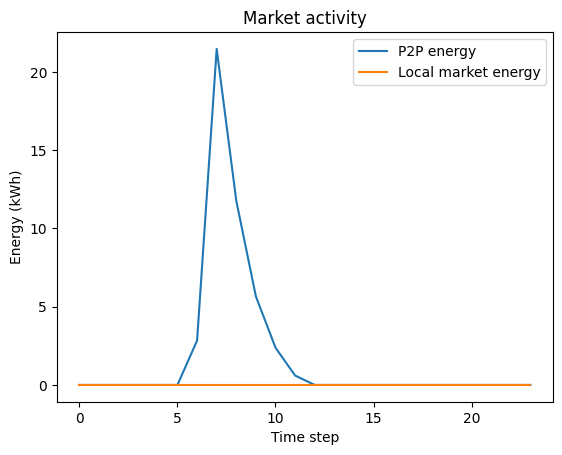

In [6]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history["p2p_energy"], label="P2P energy")
plt.plot(history["local_energy"], label="Local market energy")
plt.xlabel("Time step")
plt.ylabel("Energy (kWh)")
plt.legend()
plt.title("Market activity")
plt.show()


In [7]:
history = results["history"]


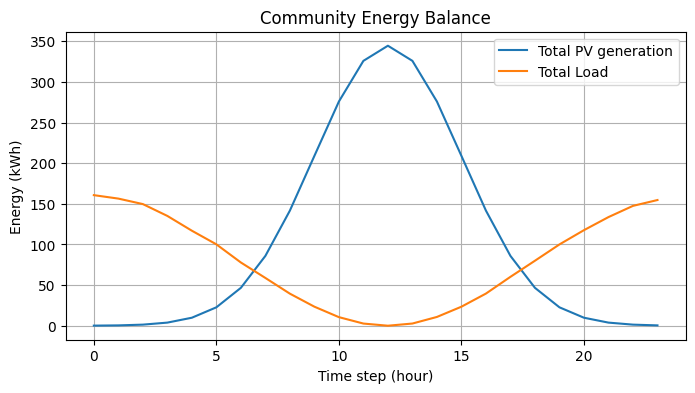

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(history["total_pv"], label="Total PV generation")
plt.plot(history["total_load"], label="Total Load")
plt.xlabel("Time step (hour)")
plt.ylabel("Energy (kWh)")
plt.title("Community Energy Balance")
plt.legend()
plt.grid(True)
plt.show()


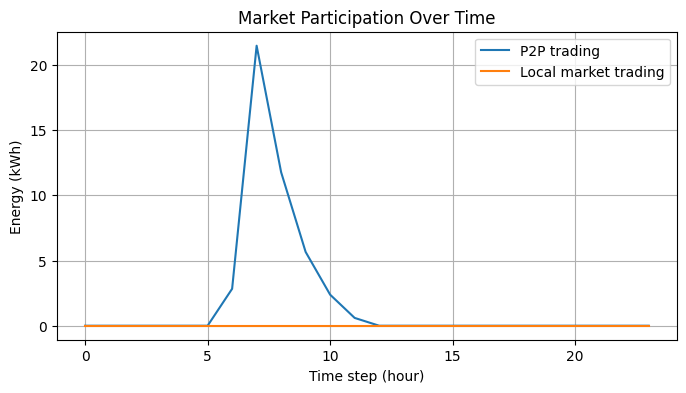

In [9]:
plt.figure(figsize=(8,4))
plt.plot(history["p2p_energy"], label="P2P trading")
plt.plot(history["local_energy"], label="Local market trading")
plt.xlabel("Time step (hour)")
plt.ylabel("Energy (kWh)")
plt.title("Market Participation Over Time")
plt.legend()
plt.grid(True)
plt.show()


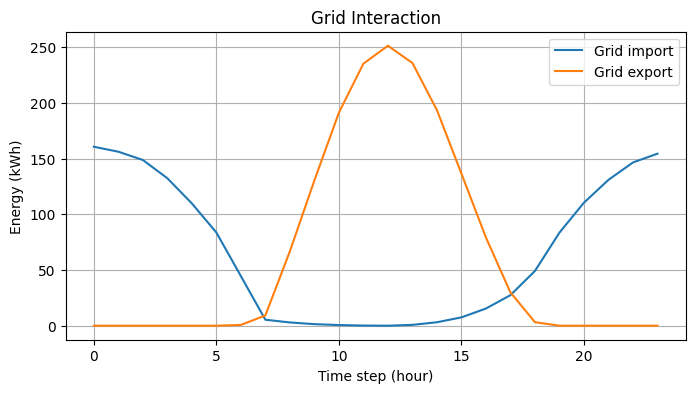

In [10]:
plt.figure(figsize=(8,4))
plt.plot(history["grid_import"], label="Grid import")
plt.plot(history["grid_export"], label="Grid export")
plt.xlabel("Time step (hour)")
plt.ylabel("Energy (kWh)")
plt.title("Grid Interaction")
plt.legend()
plt.grid(True)
plt.show()


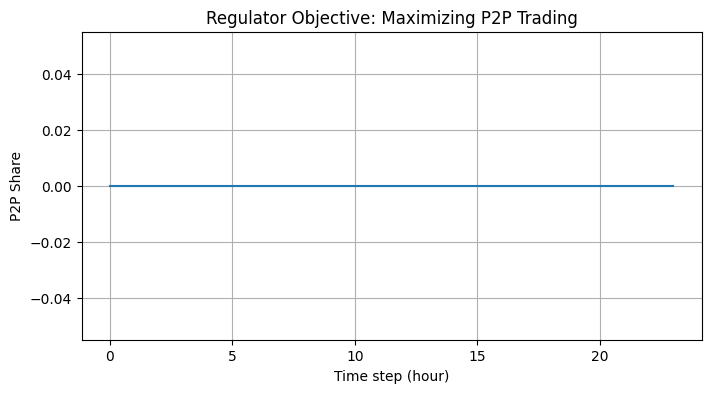

In [11]:
plt.figure(figsize=(8,4))
plt.plot(history["objective_value"])
plt.xlabel("Time step (hour)")
plt.ylabel("P2P Share")
plt.title("Regulator Objective: Maximizing P2P Trading")
plt.grid(True)
plt.show()


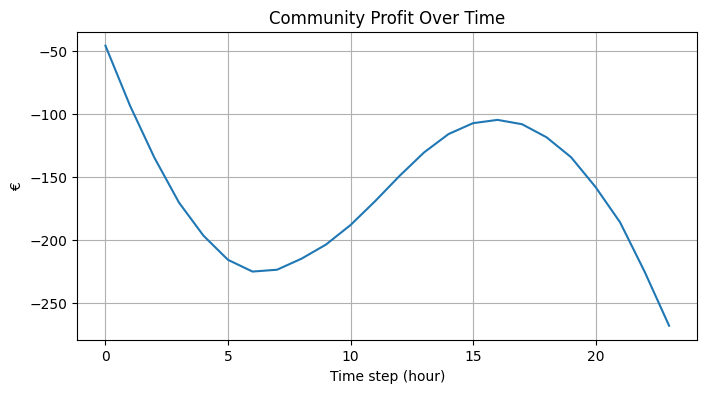

In [12]:
plt.figure(figsize=(8,4))
plt.plot(history["community_profit"])
plt.xlabel("Time step (hour)")
plt.ylabel("€")
plt.title("Community Profit Over Time")
plt.grid(True)
plt.show()
